HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

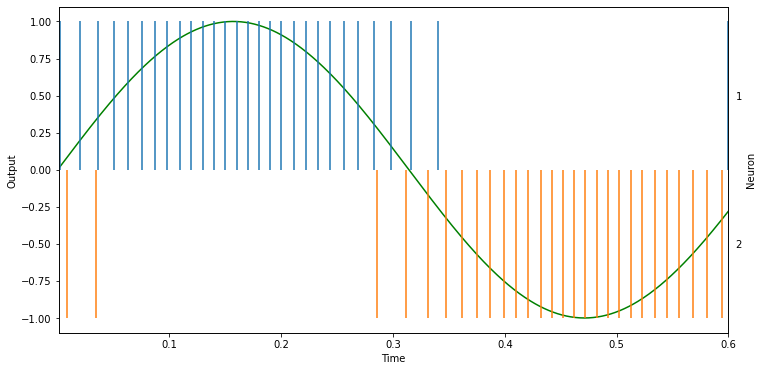

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import nengo
from nengo.utils.matplotlib import rasterplot

model = nengo.Network(label='Decoding with Two Neurons')

with model:
    stim = nengo.Node(lambda t: np.sin(10 * t))
    ens = nengo.Ensemble(2, dimensions=1,
         encoders=[[1], [-1]], intercepts=[-.5, -.5],
         max_rates=[100, 100])
    nengo.Connection(stim, ens)
    stim_p = nengo.Probe(stim)
    spikes_p = nengo.Probe(ens.neurons)

sim = nengo.Simulator(model)
sim.run(.6)

#nengo.utils.matplotlib.plot_tuning_curves(ens, sim)

t = sim.trange()
plt.figure(figsize=(12, 6))
plt.plot(t, sim.data[stim_p], 'g')
ax = plt.gca()
plt.ylabel("Output")
plt.xlabel("Time");
rasterplot(t, sim.data[spikes_p], ax=ax.twinx(), use_eventplot=True)
plt.ylabel("Neuron");

plt.show()

In [ ]:

import nengo


syn = 0.2 # slow to match paper (0.8s delay on up, 0.4 down)
plant = None #seed for model generation

def flipflop(x): 
    if x[1] > 0.2: #if trigger
        #return -2*x[0] + 1 #return +/-1
        # cheat for dev
        if x[0] > 0.5:
            return -1
        else:
            return 1
    else:
        return 0
        
def stay(x):#cheating for dev
    if x > 0.5:
        return 1
    else:
        return 0

def pulse_(x,step):#generate pulse of random amplitude every step s
    if x % step > step - 0.1:
        #inp = round(np.random.uniform(0.1, 1.0), 2)
        #return inp
        return 1
    else:
        return 0
        

class MothBrainNengo(nengo.Network):
    def __init__(self, noise=0, inhib=3, N=100):
        super(MothBrainNengo, self).__init__()
        with self:
            ### Left side ###
            self.inputL = nengo.Node(None, size_in=1)
            #state[0] holds value, state[1] holds trigger
            self.stateL = nengo.Ensemble(N,2, max_rates = nengo.dists.Uniform(80, 200),
                        intercepts = nengo.dists.Uniform(0,1), seed = plant)
            
            ### Right side ### 
            
            self.inputR = nengo.Node(None, size_in=1)
            self.stateR = nengo.Ensemble(N,2, max_rates = nengo.dists.Uniform(80, 200),
                        intercepts = nengo.dists.Uniform(0,1), seed = plant)
            
            ### Connections ###
            nengo.Connection(self.inputL, self.stateL[1], synapse=syn/10) #Trigger
            nengo.Connection(self.stateL[0],self.stateL[0], synapse=syn/2, function=stay) #Memory
            nengo.Connection(self.stateL, self.stateL[0], synapse=syn, function=flipflop)#Update Value
            
            nengo.Connection(self.inputR, self.stateR[1], synapse=syn/10) #Trigger
            nengo.Connection(self.stateR[0],self.stateR[0], synapse=syn/2, function=stay) #Memory
            nengo.Connection(self.stateR, self.stateR[0], synapse=syn, function=flipflop)#Update Value
            
            ### Recurrent inhibition ###
            self.PBN_r_slow = nengo.Ensemble(N,1, max_rates = nengo.dists.Uniform(20, 100),
                        intercepts = nengo.dists.Uniform(-.4,0), seed = plant,
                        encoders = [[1]]*N) 
            self.PBN_l_slow = nengo.Ensemble(N,1, max_rates = nengo.dists.Uniform(20, 100),
                        intercepts = nengo.dists.Uniform(-.4,0), seed = plant,
                        encoders = [[1]]*N)
                        
            self.PBN_r_fast = nengo.Ensemble(N,1, max_rates = nengo.dists.Uniform(20, 100),
                        intercepts = nengo.dists.Uniform(-.4,0), seed = plant,
                        encoders = [[1]]*N)
            self.PBN_l_fast = nengo.Ensemble(N,1, max_rates = nengo.dists.Uniform(20, 100),
                        intercepts = nengo.dists.Uniform(-.4,0), seed = plant,
                        encoders = [[1]]*N)
            # Connections
            nengo.Connection(self.PBN_l_slow, self.stateR.neurons, transform = [[-0.5]] * N, synapse=0.5)# slow as in Kanzaki & Shibuya 1992
            nengo.Connection(self.PBN_r_slow, self.stateL.neurons, transform = [[-0.5]] * N, synapse=0.5)
            nengo.Connection(self.inputR, self.PBN_r_slow, synapse=0.1)#was stateL[1]
            nengo.Connection(self.inputL, self.PBN_l_slow, synapse=0.1)#was stateR[1]
            nengo.Connection(self.stateR[0], self.PBN_l_fast, synapse=0.5)
            nengo.Connection(self.stateL[0], self.PBN_r_fast, synapse=0.5)

            #nengo.Connection(PBN_r, PBN_r[0], synapse=0.05, function = lambda x: x[0]*x[1])
            #nengo.Connection(PBN_l, PBN_l[0], synapse=0.05, function = lambda x: x[0]*x[1])


            #GII-A DN - briefly excited neurons used for straight walking *************
            self.giia_l = nengo.Ensemble(N, 1, max_rates = nengo.dists.Uniform(20, 40))
            self.giia_r = nengo.Ensemble(N, 1, max_rates = nengo.dists.Uniform(20, 40))
            nengo.Connection(self.PBN_r_fast, self.giia_l.neurons, synapse=0.05, transform = [[-3]] * N)
            nengo.Connection(self.PBN_l_fast, self.giia_r.neurons, synapse=0.05, transform = [[-3]] * N)
            nengo.Connection(self.stateR[0], self.giia_l, synapse = 0.05)
            nengo.Connection(self.stateL[0], self.giia_r, synapse = 0.05)

            
            ### Motor ###
            self.turn = nengo.Ensemble(N, 1, seed=plant) #L = 1, R = -1
            
            nengo.Connection(self.stateL[0], self.turn, transform = 1)
            nengo.Connection(self.stateR[0], self.turn, transform = -1)
            nengo.Connection(self.giia_r, self.turn.neurons, transform = [[-inhib]]*N)
            nengo.Connection(self.giia_l, self.turn.neurons, transform = [[-inhib]]*N)

        if noise > 0:
            for ens in self.all_ensembles:
                ens.noise = nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(mean=0, std=noise))
